## Setup and Imports


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

## Class Definition: CRNN


In [80]:
class CRNN(nn.Module):
    def __init__(self, n_mels=64, hidden_size=64, output_size=3):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.25)
        )

        self.gru = nn.GRU(input_size=32 * (n_mels // 4),
                          hidden_size=hidden_size,
                          batch_first=True,
                          bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, h = self.gru(x)
        h_concat = torch.cat([h[0], h[1]], dim=1)
        return self.fc(h_concat)

## Class Definition: RIRDataset


In [82]:
class RIRDataset(Dataset):
    def __init__(self, features_dir="features", labels_dir="labels", max_len=160):
        self.features_dir = features_dir
        self.labels_dir = labels_dir
        self.file_list = sorted([f for f in os.listdir(features_dir) if f.endswith(".npy")])
        self.max_len = max_len

        self.label_mean = np.array([1.5, -100.0, -4.0], dtype=np.float32)
        self.label_std = np.array([0.75, 10.0, 3.0], dtype=np.float32)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        x = np.load(os.path.join(self.features_dir, self.file_list[idx])).astype(np.float32)
        y = np.load(os.path.join(self.labels_dir, self.file_list[idx])).astype(np.float32)

        x = (x - np.mean(x)) / (np.std(x) + 1e-8)

        if x.shape[1] < self.max_len:
            x = np.pad(x, ((0, 0), (0, self.max_len - x.shape[1])), mode='constant')
        elif x.shape[1] > self.max_len:
            x = x[:, :self.max_len]

        y = (y - self.label_mean) / self.label_std
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

## Set Device


In [84]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load test set
test_dataset = RIRDataset()
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize and load model
model = CRNN().to(device)
model.load_state_dict(torch.load("", map_location=device)) # Load Trained Model .pt Format
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (gru): GRU(512, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

## Denormalization Constants


In [86]:
# Denormalization constants (match training)
label_mean = np.array([1.5, -100.0, -4.0], dtype=np.float32)
label_std = np.array([0.75, 10.0, 3.0], dtype=np.float32)

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device).float()
        y = y.to(device).float()
        outputs = model(x)

        # Denormalize
        preds = outputs.cpu().numpy() * label_std + label_mean
        targets = y.cpu().numpy() * label_std + label_mean

        all_preds.append(preds)
        all_targets.append(targets)

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

## Target Names Definition


In [87]:
target_names = ["RT60", "DRR", "C50"]
target_indices = [1, 0, 2]

for i, name in zip(target_indices, target_names):
    mae = mean_absolute_error(all_targets[:, i], all_preds[:, i])
    rmse = np.sqrt(mean_squared_error(all_targets[:, i], all_preds[:, i]))
    r2 = r2_score(all_targets[:, i], all_preds[:, i])
    corr, _ = pearsonr(all_targets[:, i], all_preds[:, i])

    print(f"🔹 {name} Metrics:")
    print(f"   MAE    : {mae:.4f}")
    print(f"   RMSE   : {rmse:.4f}")
    print(f"   R2     : {r2:.4f}")
    print(f"   Pearson: {corr:.4f}\n")

🔹 RT60 Metrics:
   MAE    : 1.5286
   RMSE   : 1.9410
   R2     : 0.9087
   Pearson: 0.9680

🔹 DRR Metrics:
   MAE    : 0.1514
   RMSE   : 0.2180
   R2     : 0.8995
   Pearson: 0.9640

🔹 C50 Metrics:
   MAE    : 0.5938
   RMSE   : 0.7415
   R2     : 0.9888
   Pearson: 0.9964



# Plotting the Results

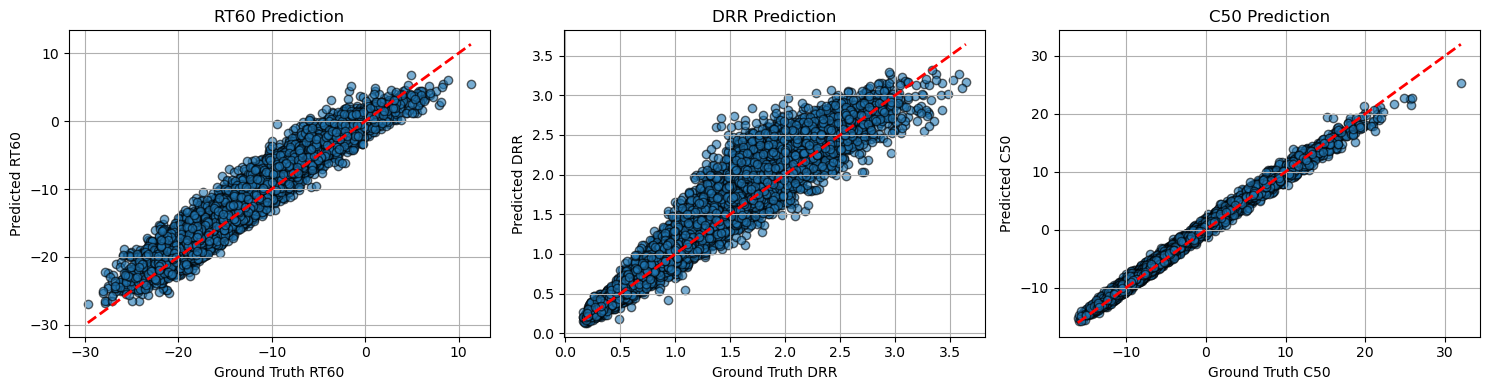

In [90]:
target_names = ["RT60", "DRR", "C50"]
target_indices = [1, 0, 2]  # same as used in metrics

plt.figure(figsize=(15, 4))

for i, (idx, name) in enumerate(zip(target_indices, target_names)):
    plt.subplot(1, 3, i+1)
    plt.scatter(all_targets[:, idx], all_preds[:, idx], alpha=0.6, edgecolors='k')
    plt.plot([all_targets[:, idx].min(), all_targets[:, idx].max()],
             [all_targets[:, idx].min(), all_targets[:, idx].max()],
             'r--', linewidth=2)
    plt.xlabel(f"Ground Truth {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"{name} Prediction")
    plt.grid(True)

plt.tight_layout()
plt.show()